---
**Project**: Cable Burial Operability  
**Author**: Alejandra L. Cameselle  
**Date**: June 2025  
**Notebook**: 05 – Operational Complexity Scoring

### Description
This notebook classifies each grid cell based on operational complexity for submarine cable burial. It uses bathymetry and slope criteria to determine if burial is required, and whether it is feasible based on slope.

### Operational Complexity Classification Criteria

The classification of operational complexity is based on two main geotechnical constraints:

- **Cable burial is required** when water depth is **< 1000 m**.
- **Burial is only feasible** on slopes **≤ 7°**.

| Class       | Depth Condition             | Slope Condition        | Justification                                                                 |
|-------------|-----------------------------|------------------------|--------------------------------------------------------------------------------|
| **Critical**| `< 1000 m` (burial required) | `> 7°` (burial not feasible) | High operational risk — burial required but technically not feasible.         |
| **High**    | `≥ 1000 m` (no burial needed)| `> 7°` (steep slope)   | No burial needed, but slope could cause cable instability.                   |
| **Moderate**| `< 1000 m` (burial required) | `5° – 7°` (at limit)   | Burial may be feasible, but near the technical limit — moderate complexity.   |
| **Low**     | All other cases             |                        | Low-risk area for deployment.                                                 |

### Inputs
- `04_grid_operability.gpkg`: Grid with `depth_mean`, `slope_mean_deg`, and burial requirement/feasibility flags.

### Processing
- Apply decision rules based on depth and slope thresholds:
    - Critical: depth < 1000 m and slope > 7º
    - High: depth ≥ 1000 m and slope > 7º
    - Moderate: depth < 1000 m and slope between 5º–7º
    - Low: all other cases
- Assign `cell_complexity` field
- Visualize the classified grid

### Outputs
- `05_grid_operational_complexity.gpkg`: Grid with operational complexity class per cell
- `05_cell_complexity_map.png`: Map of operational complexity classes

### Assumptions
- Depth is negative (i.e., deeper means more negative)
- Slope values are expressed in degrees
- Burial is required if depth > –1000 m (i.e., less negative)
- Burial is not feasible when slope exceeds 7º

### Dependencies
- geopandas, pandas, matplotlib

In [1]:
# Import libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [2]:
# Load operability grid
grid = gpd.read_file("../processed_data/04_grid_operability.gpkg")

In [3]:
# Assign operational complexity class using slope in degrees
conditions = [
    (grid["depth_mean"] >= -1000) & (grid["slope_mean_deg"] > 7),
    (grid["depth_mean"] < -1000) & (grid["slope_mean_deg"] > 7),
    (grid["depth_mean"] >= -1000) & (grid["slope_mean_deg"].between(5, 7, inclusive="left"))
]
choices = ["Critical", "High", "Moderate"]
grid["cell_complexity"] = pd.Categorical(
    np.select(conditions, choices, default="Low"),
    categories=["Critical", "High", "Moderate", "Low"],
    ordered=True
)

In [4]:
# Save output
os.makedirs("../processed_data", exist_ok=True)
fname = f"../processed_data/05_grid_operational_complexity.gpkg"
layer = f"05_grid_operational_complexity"
grid.to_file(fname, layer=layer, driver="GPKG")

print(f"Grid exported: {fname}")

Grid exported: ../processed_data/05_grid_operational_complexity.gpkg


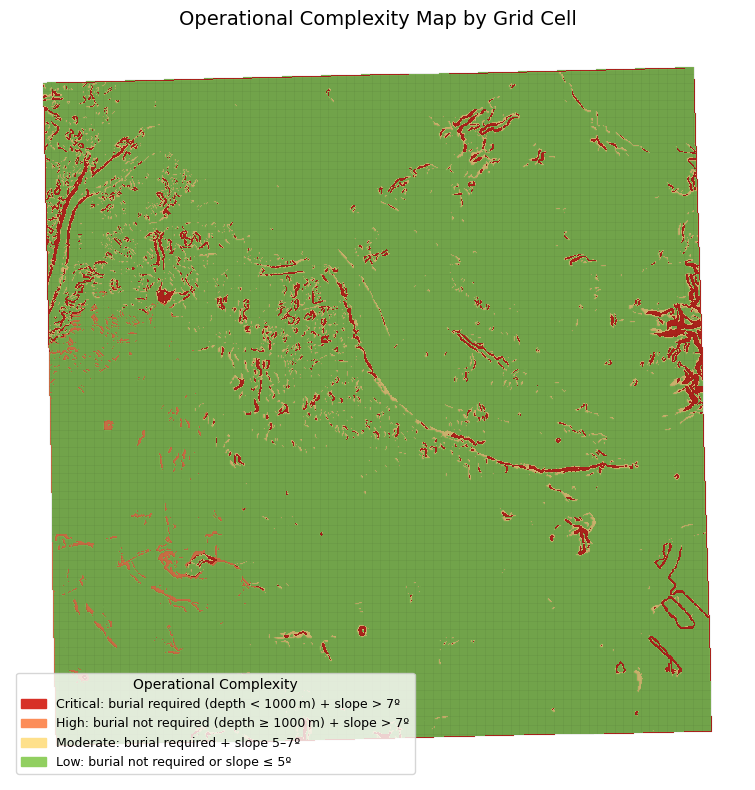

In [5]:
# Define color and descriptive labels
complexity_colors = {
    "Critical": "#d73027",   # red
    "High": "#fc8d59",       # orange
    "Moderate": "#fee08b",   # yellow
    "Low": "#91cf60"         # green
}

legend_labels = {
    "Critical": "Critical: burial required (depth < 1000 m) + slope > 7º",
    "High": "High: burial not required (depth ≥ 1000 m) + slope > 7º",
    "Moderate": "Moderate: burial required + slope 5–7º",
    "Low": "Low: burial not required or slope ≤ 5º"
}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
for complexity, color in complexity_colors.items():
    grid[grid["cell_complexity"] == complexity].plot(ax=ax, color=color, edgecolor="black", linewidth=0.05)

# Custom legend
legend_patches = [
    mpatches.Patch(color=complexity_colors[key], label=legend_labels[key])
    for key in ["Critical", "High", "Moderate", "Low"]
]
ax.legend(handles=legend_patches, title="Operational Complexity", loc='lower left', fontsize=9, title_fontsize=10)

plt.title("Operational Complexity Map by Grid Cell", fontsize=14)
plt.axis("off")
plt.tight_layout()

# Save PNG
os.makedirs("../outputs/maps", exist_ok=True)
plt.savefig("../outputs/maps/05_operational_complexity_map.png", dpi=300)
plt.show()